<div align=center>

<br/>
<font size=4>
        <b>
        In the Name of God
    </b>
    </font>
    <br/>
    <br/>
    <font align=center size=5>
        <br/>
        Project
        <br/><br/>
        <font color=blue size=5>
            Face Recognition
        </font>
        <br/>
        <br/>
    </font>
    <hr/>
    <font size=4>
         Dr. Mazlaghani
        <br/>
        <br/>
        <br/>
        Winter 2023
        <br/>
        <br/>
    </font>
    <br/>
    <br/>
    <br/>
</div>

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<div dir="rtl">
    <h1>
        تشخیص چهره
    </h1>
</div>

<div dir="rtl" style="font-size:18px">
    در الگوریتم‌های تشخیص چهره، درون عکس‌ها به دنبال تشخیص خصوصیت‌های خاص عکس بودند. به طور مثال چشم، بینی و ...
     که می‌توانست حاکی از وجود چهره در عکس باشند. واضح است که چنین روش‌هایی هزینه‌بر و در موارد زیادی نادقیق هستند.
    <br/>
    <br/>
    در این پروژه به دنبال پیاده سازی روشی هستیم که بتوانیم این تشخیص را با استفاده از مفاهیم آموخته شده به نحو موثری انجام دهیم.
    </div>

## Load Data (10 points)



<br/>

<div dir="rtl" style="font-size:18px">
    قبل از اینکه درباره پیاده‌سازی این الگوریتم صحبت کنیم لازم است داده‌هایی که مورد استفاده قرار می‌دهیم را داشته باشیم.
    داده‌های مورد نظر در زیپ مربوطه همراه این نوتبوک قرار گرفته‌است.
    <br/>
    دقت کنید که این دیتاست شامل تصاویر مربوط به چهره 200 فرد است.
    هر کدام از افراد دو عکس یکی حالت طبیعی و یکی خندان دارند.
    پس در کل 400 عکس داریم.
    ابتدا تمام عکس‌ها را لود کنید و داشته باشید که در ادامه به آن‌ها نیاز پیدا می‌کنید.
    <br/>
    <br/>
    در نهایت برای این که مطمئن شوید که دیتا را درست لود کرده‌اید،
    به طور رندوم 5 تا از این چهره‌ها را در دو حالت خندان و عادی نمایش دهید. برای اینکار میتوانید از تابع imshow از لایبرری matplotlib استفاده کنید.
    <br/>
</div>

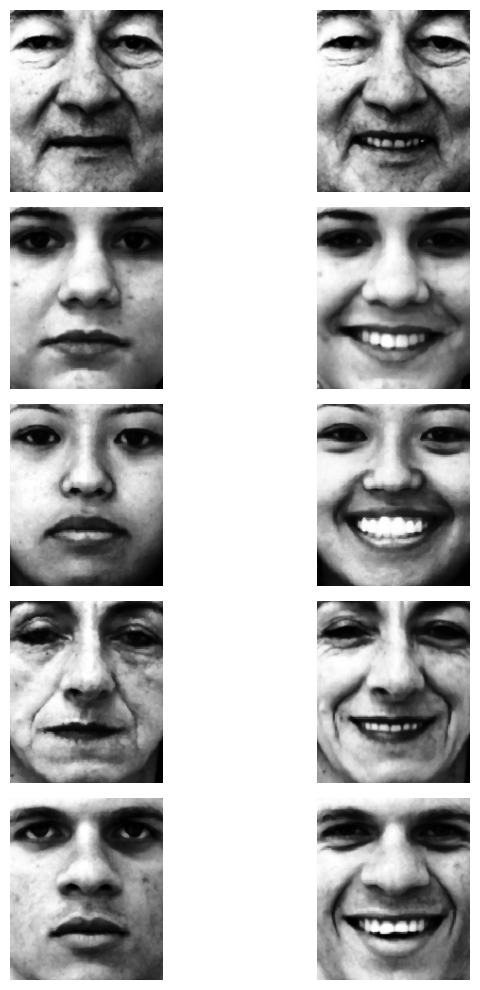

In [17]:
import os
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
dataset_dir = '/content/drive/MyDrive/face_dataset'

# loading pictures
faces = {}

for i in range(1,201):
  smile_path = os.path.join(dataset_dir , f'{i}b.jpg')
  normal_path = os.path.join(dataset_dir , f'{i}a.jpg')

  if os.path.exists(smile_path) and os.path.exists(normal_path) :
    nor_img = cv2.imread(normal_path , cv2.IMREAD_GRAYSCALE)
    smi_img = cv2.imread(smile_path , cv2.IMREAD_GRAYSCALE)
    faces[i] = [nor_img , smi_img]

random_list_num = random.sample(range(1 , 200)  ,5)
random_pic_5 = {}
for i in random_list_num:
  random_pic_5[i] = faces[i]

#show first 5
fig , axes = plt.subplots(5,2,figsize=(8,10))
for idx , (person_id , (normal , smile)) in enumerate(list(random_pic_5.items())):
    axes[idx , 0].imshow(normal , cmap='gray')
    axes[idx , 0].axis('off')
    axes[idx,1].imshow(smile , cmap='gray')
    axes[idx , 1 ].axis('off')


plt.tight_layout()
plt.show()



<br/>
<div dir="rtl" style="font-size:18px">
حال فعلا تنها با عکس‌های چهره طبیعی کار داریم.
    190 تا عکس اول از آن را در نظر بگیرید
     هر کدام را به صورت یک وکتور تک بعدی $\Gamma_i$ در بیاورید.
     در نهایت ماتریس حاصل از داده‌ها که $\Gamma$ است
    را تشکیل دهید. دقت کنید که ستون $i$ ام این ماتریس
    $\Gamma_i$ است.
    <br/>
<div/>

In [18]:
norm_vec_faces = []
for i in range(1,191):
  vectorized_img = faces[i][0].flatten()
  norm_vec_faces.append(vectorized_img) #normal one is 0 index

gamma = np.column_stack(norm_vec_faces)
print('shape : ' , gamma.shape)

shape :  (31266, 190)


# PCA
<br/>
<br/>

<div dir="rtl" style="font-size:18px">
 <br/>
    الگوریتم Principal Component Analysis یا همان PCA یک روش برای کاهش ابعاد داده‌ی موردنظر است که در حوزه یادگیری ماشین و علوم داده کاربرد فراوان دارد.
با کاهش ابعاد سادگی را افزایش داده و در عین حال همانگونه که انتظار می‌رود ورودی با کاهش دقت همراه خواهد شد. در الگوریتم PCA تلاش بر این است که در عین کاهش ابعاد، کمترین میزان اطلاعات را از دست بدهیم.
    پیشنهاد می‌شود قبل از انجام پروژه مطالعات بیشتری در رابطه با این الگوریتم داشته باشید.
<br/>
    <br/>
در ادامه‌ی بخش‌ها می‌خواهیم PCA را پیاده سازی کنیم.
گفتیم که برای تشخیص چهره‌ها به دنبال پیدا کردن مشخصه‌های خاص درون هر عکس هستیم. این مشخصه‌ها ممکن است ترکیبی از چندویژگی درون عکس باشند، یا حتی ویژگی‌هایی
    باشند که به طور طبیعی قادر به تشخیص آنها نیستیم.
    در اینجا با استفاده از الگوریتم PCA در تلاش برای پیدا کردن همچین ویژگی‌هایی هستیم.
    <br/>
    <br/>
با PCA قرار است کار زیر را انجام دهیم :
    <br/>
    <br/>
فرض کنید هر عکس به صورت یک آرایه دو بعدی $N\times M$ باشد ، بنابراین هر عکس را می‌توان با یک بردار به طول $N\times M$ نشان دهیم، پس در یک فضای $N\times M$ بعدی قرار دارد. فرض کنید $W$ فضایی باشد که تمامی عکس‌های صورت در آن قرار دارند ، اسم آن را Face Space بگذارید. در اینجا به دنبال پیدا کردن K بردار عمود بر هم هستیم که فضای $W$ را Span می‌کنند.
    <div/>

## Mean image (5 points)

<div dir="rtl" style="font-size:18px">
    
<div/>

<div dir="rtl" style="font-size:18px">
    در این قسمت برای نرمالایز کردن نیاز به
    mean image
    داریم.
    آن را بدست آورید و تصویر آن را نمایش هم دهید.
    $$
    \Psi = \frac{1}{n}\sum_{i = 1}^{n} \Gamma_i
    $$
     در اینجا $n$ تعداد داده های شماست.
     دقت کنید فعلا کل کار ما بر روی 190 عکس چهره طبیعی است.
<div/>

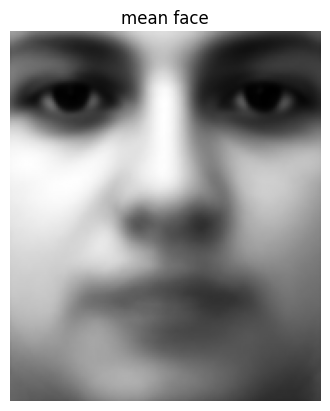

In [19]:
mean_face = np.mean(gamma, axis=1).reshape(nor_img.shape)
plt.imshow(mean_face, cmap='gray')
plt.title("mean face")
plt.axis("off")
plt.show()


## Cov Matrix (15 points)

<div dir="rtl" style="font-size:18px">
    
<div/>

<div dir="rtl" style="font-size:18px">
    در این قسمت باید ماتریس کوواریانس را به صورت زیر تعریف کنید :
    <br/>
    $$
    \Phi_i = \Gamma_i - \Psi
    $$
    <br/>
    $$
    A = [ \Phi_1 \Phi_2 \dots \Phi_n ]
    $$
    <br/>
    $$
    C = A A^T
    $$
    <br/>
    حال بردار ویژه های ماتریس $C$ به ترتیب بزرگی مقدار ویژه های متناظرشان ، Principal Components هایی هستند که ما می‌خواهیم.
    <br/>
    دقت کنید که ماتریس $C$ ماتریسی $N^2\times N^2$ می‌باشد ، سعی کنید روش بهینه ای برای پیدا کردن بردار ویژه های آن پیاده سازی کنید.
    به عنوان راهنمایی از
    $A^T A$
    کمک بگیرید.
    <br/>
    مقدار این مقادیر ویژه را سورت کنید و درون یک نمودار نشان دهید.
    <br/>
    بعد از سورت کردن مقدار ویژه‌ها ، بردار ویژه متناظر با 5 مقدار ویژه اول را بکشید.
    این بردار‌های ویژه را eigen face می‌نامیم.
    <br/>
     در نهایت با کمی مطالعه معیاری را انتخاب کنید و تعداد مورد نیاز از Principal Component
     ها از نظرتان را مشخص نمایید و آن تعداد بردار ویژه را انتخاب کنید.
     این عدد را K در نظر بگیرید.
     همچنین ماتریس شامل PCها را U در نظر بگیرید.
    <br/>
<div/>

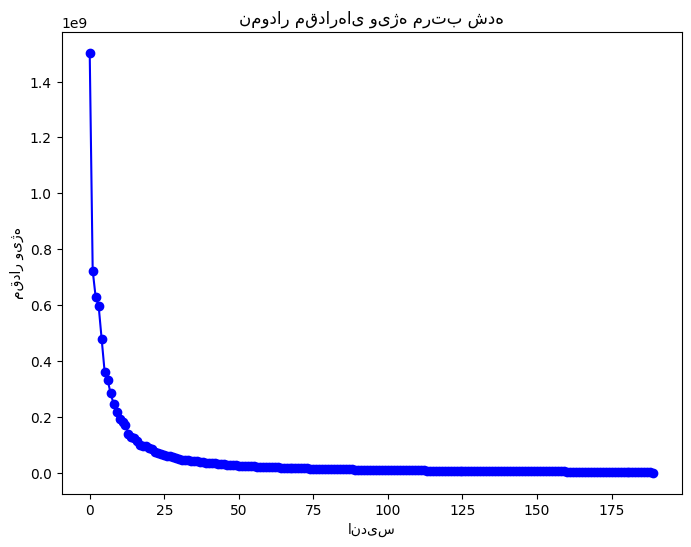

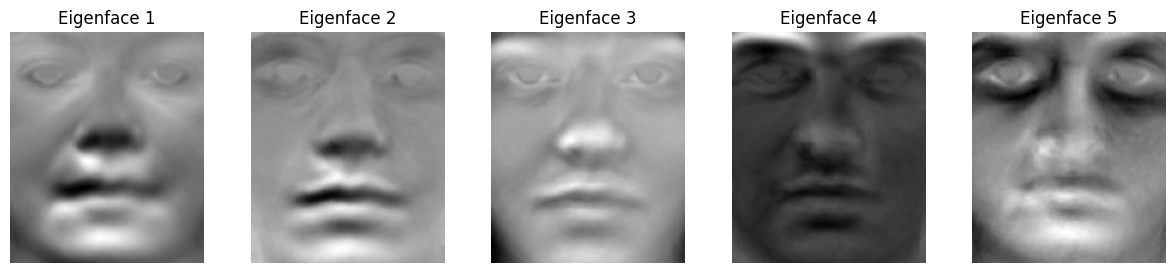

تعداد مؤلفه‌های اصلی انتخاب شده (K): 62


In [20]:

# محاسبه تصاویر مرکز شده: phi_i = Gamma_i - Psi
Psi = mean_face.flatten()         # نتیجه: shape (31266,)
Psi = Psi[:, np.newaxis]          # تغییر شکل به (31266, 1)

A = gamma - Psi

# محاسبه ماتریس کوچک L = A^T A (ابعاد n x n)
L = np.dot(A.T, A)

# محاسبه بردارهای ویژه و مقدارهای ویژه ماتریس L
eigvals, eigvecs = np.linalg.eig(L)

# مرتب‌سازی مقدارهای ویژه به ترتیب نزولی
sorted_indices = np.argsort(eigvals)[::-1]
eigvals_sorted = eigvals[sorted_indices]
eigvecs_sorted = eigvecs[:, sorted_indices]

# محاسبه eigen face ها: u = A v
eigenfaces = np.dot(A, eigvecs_sorted)
# نرمالسازی eigen face ها
eigenfaces = eigenfaces / np.linalg.norm(eigenfaces, axis=0)

# رسم نمودار مقدارهای ویژه مرتب شده
plt.figure(figsize=(8, 6))
plt.plot(eigvals_sorted, 'bo-')
plt.title("نمودار مقدارهای ویژه مرتب شده")
plt.xlabel("اندیس")
plt.ylabel("مقدار ویژه")
plt.show()

# نمایش 5 eigen face برتر
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
h,w = 193 , 162
for i in range(5):
    eigenface_img = eigenfaces[:, i].reshape(h, w)
    axes[i].imshow(eigenface_img, cmap='gray')
    axes[i].set_title(f"Eigenface {i+1}")
    axes[i].axis('off')
plt.show()

# انتخاب تعداد PC ها بر اساس واریانس توضیح داده شده
total_variance = np.sum(eigvals_sorted)
cumulative_variance = np.cumsum(eigvals_sorted) / total_variance

# به عنوان مثال، انتخاب K به گونه‌ای که 90 درصد از واریانس کلی توضیح داده شود
K = np.searchsorted(cumulative_variance, 0.90) + 1
print("تعداد مؤلفه‌های اصلی انتخاب شده (K):", K)

# ماتریس U شامل اولین K eigen face خواهد بود
U = eigenfaces[:, :K]

## Reconstruction images (20 points)

<div dir="rtl" style="font-size:18px">
    در این قسمت قرار است که تابعی بنویسید که عکسی را به همراه
    Principal Components
    ‌های مورد نظر بگیرد و آن را دوباره با آن PC‌ها بازسازی کند.
    برای نحوه‌ی انجام این کار از روابط زیر کمک بگیرید.
    <br/>
    $$W = U^T(\Gamma - \Psi)$$
    $$rec = UW + \Psi$$
    <br/>
    دقت کنید که $\Gamma$
    این‌جا عکس ورودی است.
<div/>

<div dir="rtl" style="font-size:18px">
    
<div/>

In [21]:


def reconstruct_image(orig, pcs):
    global mean_face  # Assume mean_face is already computed and available

    # Flatten the original image and the mean_face if necessary
    orig_flat = orig.flatten()
    mean_face_flat = mean_face.flatten()

    # Center the image by subtracting the mean face
    centered = orig_flat - mean_face_flat

    # Compute the weights W = U^T (Gamma - Psi)
    W = np.dot(pcs.T, centered)

    # Reconstruct the image: rec = U * W + Psi
    rec_flat = np.dot(pcs, W) + mean_face_flat

    # Calculate the Mean Squared Error (MSE)
    mse = np.mean((orig_flat - rec_flat) ** 2)

    # Reshape the reconstructed flat image to the original image shape
    recon = rec_flat.reshape(orig.shape)
    return recon, mse


<div dir="rtl" style="font-size:18px">
    )بخش ب(
    <br/>
    حال یکی از عکس‌های دیتاستی که تا الان روی آن کار کردیم )شامل 190 عکس طبیعی( را به صورت رندم انتخاب کنید.
    برای آن عکس به ازای تمام حالت‌های انتخاب K عملیات بازسازی را انجام دهید.
    <br/>
    کمترین و بیشترین MSE را به دست آورید.
    <br/>
    MSE را برای Kای که در قسمت قبل انتخاب کردید محاسبه نمایید.
    <br/>
    سپس نمودار
    MSE-number of largest principal components
    را رسم کنید.
    <br/>
    در مرحله‌ی بعد برای یک عکس رندم دیگر از دیتاست، عکس اصلی را همراه عکس‌هایی که از بازسازی با در نظر گرفتن
    5 انتخاب مختلف برای K که کل محدوده تعداد
    eigen face‌ها را پوشش دهد،
    رسم کنید.
    <br/>
    نتایج خود را از کار‌هایی که این بخش انجام دادید و از روی خروجی‌های بدست آمده شرح دهید.
<div/>

کمترین MSE برای این تصویر: 5.451474456869831e-24
بیشترین MSE برای این تصویر: 1190.9295338523748
MSE برای K انتخاب شده (بر مبنای 90٪ واریانس): 0.40954769889765014


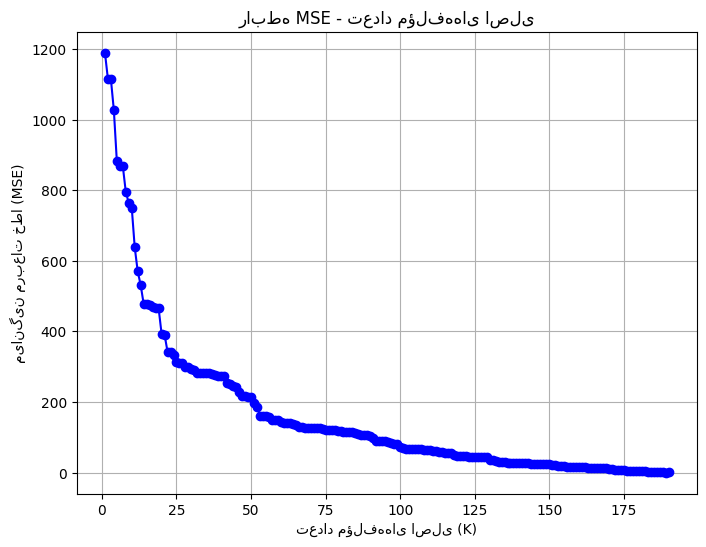

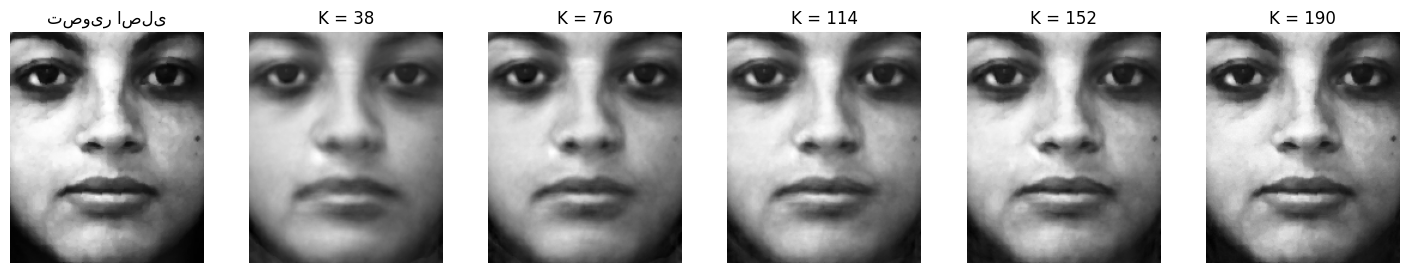

In [22]:
# بخش اول: ارزیابی MSE برای یک تصویر از دیتاست برای تمام مقادیر K

# انتخاب یک تصویر تصادفی از دیتاست
num_images = gamma.shape[1]  # فرضاً 190
img_index = random.randint(0, num_images - 1)
orig_flat = gamma[:, img_index]
orig_img = orig_flat.reshape(h, w)

# حداکثر تعداد مؤلفه‌های اصلی موجود (مثلاً 190)
max_K = eigenfaces.shape[1]

mse_values = []
K_range = range(1, max_K + 1)

for K in K_range:
    # انتخاب اولین K eigen face
    pcs_K = eigenfaces[:, :K]
    _, mse = reconstruct_image(orig_img, pcs_K)
    mse_values.append(mse)

mse_values = np.array(mse_values)
min_mse = mse_values.min()
max_mse = mse_values.max()

chosen_K = K

print("کمترین MSE برای این تصویر:", min_mse)
print("بیشترین MSE برای این تصویر:", max_mse)
print("MSE برای K انتخاب شده (بر مبنای 90٪ واریانس):", mse_values[chosen_K - 1])

# رسم نمودار MSE در برابر تعداد مؤلفه‌های اصلی
plt.figure(figsize=(8,6))
plt.plot(K_range, mse_values, 'bo-')
plt.xlabel("تعداد مؤلفه‌های اصلی (K)")
plt.ylabel("میانگین مربعات خطا (MSE)")
plt.title("رابطه MSE - تعداد مؤلفه‌های اصلی")
plt.grid(True)
plt.show()

# ------------------------
# بخش دوم: نمایش بازسازی‌های متفاوت برای یک تصویر دیگر از دیتاست

# انتخاب یک تصویر تصادفی دیگر (مطمئن می‌شویم که متفاوت از تصویر قبلی است)
other_indices = [i for i in range(num_images) if i != img_index]
img_index2 = random.choice(other_indices)
orig_flat2 = gamma[:, img_index2]
orig_img2 = orig_flat2.reshape(h, w)

K_values = [max(1, int(max_K * frac)) for frac in [0.2, 0.4, 0.6, 0.8, 1.0]]

fig, axes = plt.subplots(1, 6, figsize=(18, 3))
axes[0].imshow(orig_img2, cmap='gray')
axes[0].set_title("تصویر اصلی")
axes[0].axis('off')

for i, K_val in enumerate(K_values):
    pcs_K = eigenfaces[:, :K_val]
    rec, _ = reconstruct_image(orig_img2, pcs_K)
    axes[i+1].imshow(rec, cmap='gray')
    axes[i+1].set_title(f"K = {K_val}")
    axes[i+1].axis('off')

plt.show()

##  Smiling  images (10 points)

<div dir="rtl" style="font-size:18px">
    حال این بار تمام کار‌هایی که در بخش قبل )بخش ب( انجام دادید را تکرار کنید.
    ولی این بار به جای عکس‌های رندم از چهره‌های عادی، عکس رندم از چهره‌های خندان انتخاب کنید.
    نتایج خود را از کار‌هایی که این بخش انجام دادید و از روی خروجی‌های بدست آمده شرح دهید.
    به نظرتان دلایل تفاوت خروجی‌ها در هر قسمت نسبت به قسمت قبل چیست؟
<div/>

انتخاب تصادفی اندیس = 128
کمترین MSE برای تصویر خندان: 689.3797192878109
بیشترین MSE برای تصویر خندان: 3358.0236990060357
MSE برای K انتخاب شده (بر مبنای 90٪ واریانس) برای تصویر خندان: 694.9642606853454


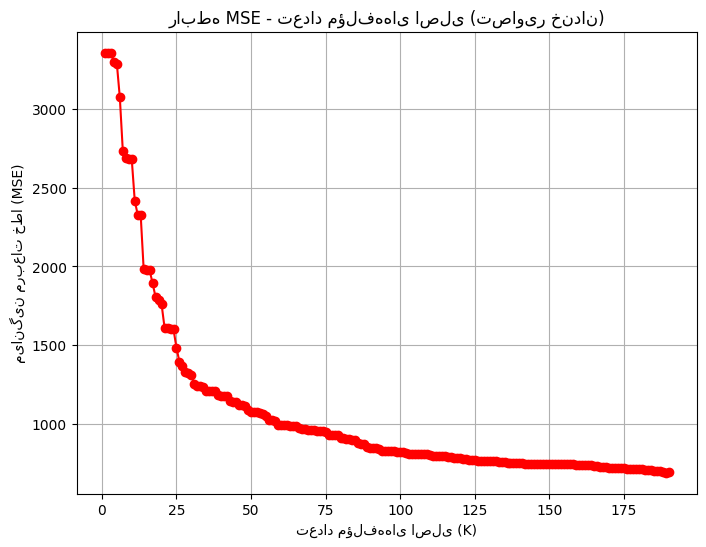

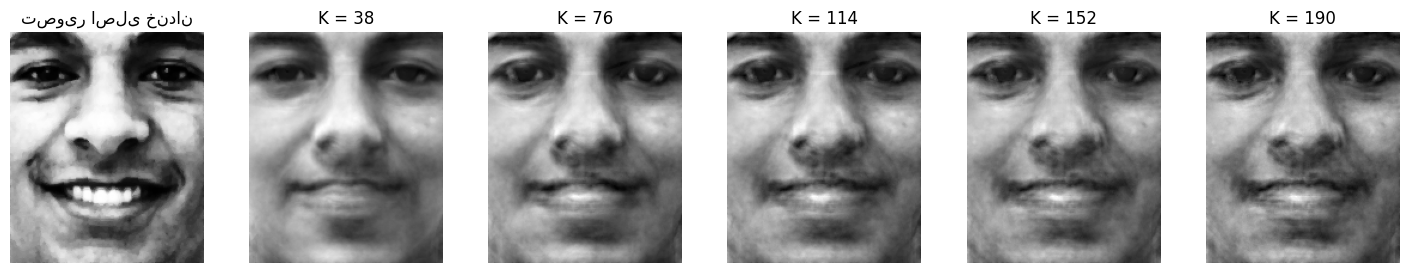

In [23]:
# آماده‌سازی ماتریس داده (gamma) برای تصاویر خندان
# فرض کنید تصاویر دارای ابعاد h x w هستند؛ در غیر این صورت باید h و w را از یکی از تصاویر استخراج کنید.
sample_img = next(iter(faces.values()))[1]  # انتخاب اولین تصویر خندان
h, w = sample_img.shape

smile_indices = list(faces.keys())
gamma = np.array([faces[i][1].flatten() for i in smile_indices]).T

img_index_smile = random.choice(smile_indices)
print("انتخاب تصادفی اندیس =", img_index_smile)

orig_flat_smile = gamma[:, smile_indices.index(img_index_smile)]
orig_img_smile = orig_flat_smile.reshape(h, w)

# حداکثر تعداد مؤلفه‌های اصلی موجود (مثلاً تعداد ستون‌های eigenfaces)
max_K = eigenfaces.shape[1]

mse_values_smile = []
K_range = range(1, max_K + 1)

for K in K_range:
    pcs_K = eigenfaces[:, :K]
    _, mse = reconstruct_image(orig_img_smile, pcs_K)
    mse_values_smile.append(mse)

mse_values_smile = np.array(mse_values_smile)
min_mse_smile = mse_values_smile.min()
max_mse_smile = mse_values_smile.max()

# فرض کنید در قسمت قبلی K بر مبنای ۹۰ درصد واریانس انتخاب شده بود؛ در اینجا به عنوان نمونه از آخرین مقدار استفاده می‌کنیم.
chosen_K_smile = K # max_K  # یا می‌توانید بر مبنای واریانس محاسبه کنید

print("کمترین MSE برای تصویر خندان:", min_mse_smile)
print("بیشترین MSE برای تصویر خندان:", max_mse_smile)
print("MSE برای K انتخاب شده (بر مبنای 90٪ واریانس) برای تصویر خندان:", mse_values_smile[chosen_K_smile - 1])

# رسم نمودار MSE در برابر تعداد مؤلفه‌های اصلی برای تصاویر خندان
plt.figure(figsize=(8,6))
plt.plot(K_range, mse_values_smile, 'ro-')
plt.xlabel("تعداد مؤلفه‌های اصلی (K)")
plt.ylabel("میانگین مربعات خطا (MSE)")
plt.title("رابطه MSE - تعداد مؤلفه‌های اصلی (تصاویر خندان)")
plt.grid(True)
plt.show()

# ------------------------
# بخش دوم: نمایش بازسازی‌های متفاوت برای یک تصویر خندان دیگر از دیتاست

other_smile_indices = [i for i in smile_indices if i != img_index_smile]
if len(other_smile_indices) == 0:
    raise ValueError("تنها یک تصویر خندان در دیتاست موجود است.")
img_index2_smile = random.choice(other_smile_indices)

orig_flat2_smile = gamma[:, smile_indices.index(img_index2_smile)]
orig_img2_smile = orig_flat2_smile.reshape(h, w)

# انتخاب 5 مقدار K متفاوت که کل محدوده eigenface‌ها را پوشش می‌دهد.
K_values = [max(1, int(max_K * frac)) for frac in [0.2, 0.4, 0.6, 0.8, 1.0]]

fig, axes = plt.subplots(1, 6, figsize=(18, 3))
axes[0].imshow(orig_img2_smile, cmap='gray')
axes[0].set_title("تصویر اصلی خندان")
axes[0].axis('off')

for i, K_val in enumerate(K_values):
    pcs_K = eigenfaces[:, :K_val]
    rec, _ = reconstruct_image(orig_img2_smile, pcs_K)
    axes[i+1].imshow(rec, cmap='gray')
    axes[i+1].set_title(f"K = {K_val}")
    axes[i+1].axis('off')

plt.show()

## Reconstruction of test set (10 points)


<div dir="rtl" style="font-size:18px">
تا به اینجای کار ما با محاسبه MSE و بازسازی دوباره  عکس‌ها به  شهودی عددی و بصری از دقت فضای جدید یا همان  face space خود رسیدیم. اما نمی‌توان از این نکته چشم‌پوشی کرد که ارزیابی‌های ما از فضای جدید با استفاده از عکس‌هایی انجام شده که با آنها face space را ساخته‌ایم. در نتیجه این ارزیابی ما به نوعی biased است. برای ارزیابی بهتر MSE را بر روی تعدادی عکس که الگوریتم آنها را تا به حال ندیده است انجام داده و آنها را بازسازی می‌کنیم.
    <br/>
    در این قسمت یک عکس از ۱۰ عکس دیده نشده حالت طبیعی را انتخاب نموده و کارهای بخش ب را بر روی آن پیاده کنید. ارزیابی چه تفاوتی کرده است؟ نتیجه‌گیری کنید.
    <br/>
<div/>

کمترین MSE برای تصویر دیده نشده: 321.14931591517603
بیشترین MSE برای تصویر دیده نشده: 1617.6940932126877
MSE برای K انتخاب شده (بر مبنای 90٪ واریانس) برای تصویر دیده نشده: 321.1921156300973


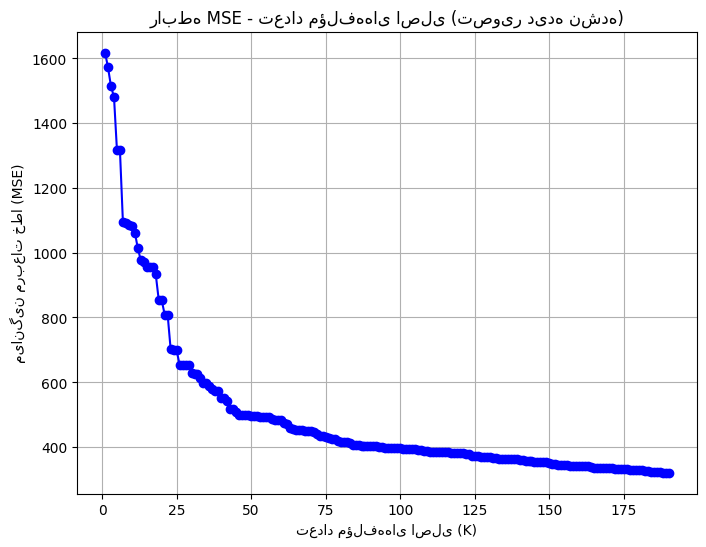

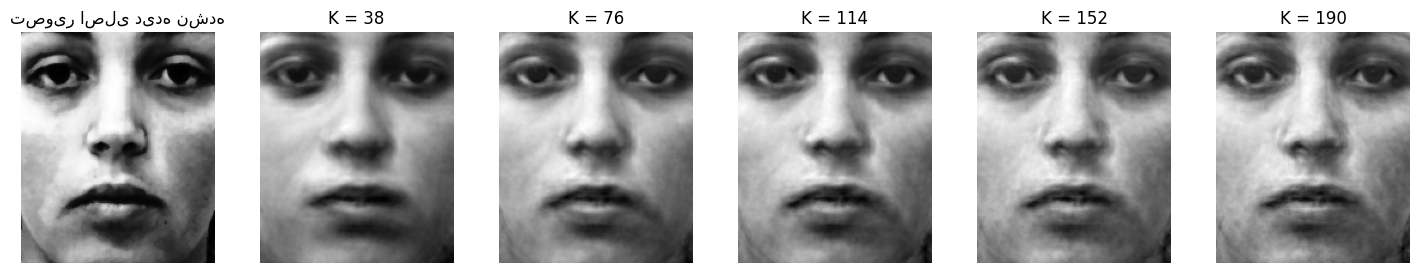

In [24]:
# بارگذاری تصاویر دیده نشده (حالت طبیعی)

unseen_normal_faces = []  # لیست تصاویر حالت طبیعی دیده نشده
#  ۱۰ تصویر دیده نشده
unseen_normal_faces = []
for i in range(191,201):
  vectorized_img = faces[i][0]
  unseen_normal_faces.append(vectorized_img) #normal one is 0 index

if len(unseen_normal_faces) < 10:
    raise ValueError("تعداد تصاویر دیده نشده کافی نیست.")

# انتخاب یک تصویر تصادفی از میان تصاویر دیده نشده حالت طبیعی
selected_unseen_img = random.choice(unseen_normal_faces)
h_unseen, w_unseen = selected_unseen_img.shape


max_K = eigenfaces.shape[1]  # تعداد کل مؤلفه‌های اصلی موجود

mse_values_unseen = []
K_range = range(1, max_K + 1)

for K in K_range:
    # انتخاب اولین K eigenface
    pcs_K = eigenfaces[:, :K]
    # تابع reconstruct_image تصویر را بازسازی و خطای MSE را محاسبه می‌کند
    _, mse = reconstruct_image(selected_unseen_img, pcs_K)
    mse_values_unseen.append(mse)

mse_values_unseen = np.array(mse_values_unseen)
min_mse_unseen = mse_values_unseen.min()
max_mse_unseen = mse_values_unseen.max()
chosen_K_unseen = max_K  # یا انتخاب بر مبنای واریانس دلخواه (مثلاً ۹۰٪)

print("کمترین MSE برای تصویر دیده نشده:", min_mse_unseen)
print("بیشترین MSE برای تصویر دیده نشده:", max_mse_unseen)
print("MSE برای K انتخاب شده (بر مبنای 90٪ واریانس) برای تصویر دیده نشده:",
      mse_values_unseen[chosen_K_unseen - 1])

# رسم نمودار MSE در برابر تعداد مؤلفه‌های اصلی برای تصویر دیده نشده
plt.figure(figsize=(8,6))
plt.plot(K_range, mse_values_unseen, 'bo-')
plt.xlabel("تعداد مؤلفه‌های اصلی (K)")
plt.ylabel("میانگین مربعات خطا (MSE)")
plt.title("رابطه MSE - تعداد مؤلفه‌های اصلی (تصویر دیده نشده)")
plt.grid(True)
plt.show()

# ------------------------
# نمایش بازسازی‌های متفاوت برای تصویر دیده نشده

K_values = [max(1, int(max_K * frac)) for frac in [0.2, 0.4, 0.6, 0.8, 1.0]]

fig, axes = plt.subplots(1, 6, figsize=(18, 3))
axes[0].imshow(selected_unseen_img, cmap='gray')
axes[0].set_title("تصویر اصلی دیده نشده")
axes[0].axis('off')

for i, K_val in enumerate(K_values):
    pcs_K = eigenfaces[:, :K_val]
    rec, _ = reconstruct_image(selected_unseen_img, pcs_K)
    axes[i+1].imshow(rec, cmap='gray')
    axes[i+1].set_title(f"K = {K_val}")
    axes[i+1].axis('off')

plt.show()

## Reconstruction of non-human image (10 points)

<div dir="rtl" style="font-size:18px">
دو عکس غیر از چهره انسان و به دلخواه خود )مثل عکس ماشین یا پرنده( را در نظر گرفته.
    نخست عملیات‌های لازم مثل سیاه سفید کردن یا تغییر سایز را انجام دهید.
    سپس با استفاده از تمام PCها
    سعی بر بازسازی آن داشته باشید و MSE را محاسبه نمایید.
    <br/>
    آیا الگوریتم به اندازه عکس چهره‌ها موفق عمل کرد؟‌ چرا؟ نتیجه‌گیری کنید.
    <br/>
<div/>

MSE برای تصویر ماشین: 1763.676304266649
MSE برای تصویر پرنده: 9762.268361335606


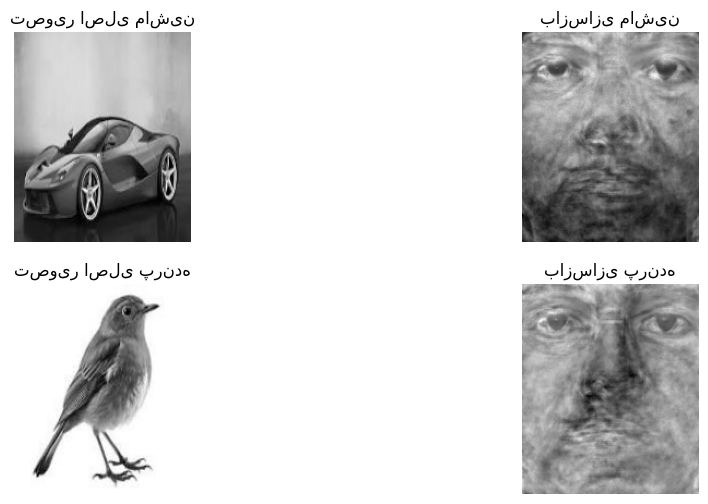

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# بارگذاری تصاویر غیر از چهره (مثلاً ماشین و پرنده)
car_path = "/content/drive/MyDrive/download.jpg"   # مسیر عکس ماشین
bird_path = "/content/download (2).jpg"   # مسیر عکس پرنده

# خواندن تصاویر به صورت سیاه و سفید
car_img = cv2.imread(car_path, cv2.IMREAD_GRAYSCALE)
bird_img = cv2.imread(bird_path, cv2.IMREAD_GRAYSCALE)

# بررسی موفقیت بارگذاری
if car_img is None or bird_img is None:
    raise ValueError("یکی از تصاویر ماشین یا پرنده به درستی بارگذاری نشد.")

# تغییر سایز تصاویر به ابعاد چهره (h x w) برای سازگاری با فضای صورت
car_img_resized = cv2.resize(car_img, (w, h))
bird_img_resized = cv2.resize(bird_img, (w, h))

# ------------------------
# بازسازی تصاویر با استفاده از تمام مؤلفه‌های اصلی (eigenfaces)
rec_car, mse_car = reconstruct_image(car_img_resized, eigenfaces)
rec_bird, mse_bird = reconstruct_image(bird_img_resized, eigenfaces)

print("MSE برای تصویر ماشین:", mse_car)
print("MSE برای تصویر پرنده:", mse_bird)

# ------------------------
# نمایش تصاویر اصلی و بازسازی شده
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.imshow(car_img_resized, cmap='gray')
plt.title("تصویر اصلی ماشین")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(rec_car, cmap='gray')
plt.title("بازسازی ماشین")
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(bird_img_resized, cmap='gray')
plt.title("تصویر اصلی پرنده")
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(rec_bird, cmap='gray')
plt.title("بازسازی پرنده")
plt.axis('off')

plt.show()


## Image Rotation (10 points)

<div dir="rtl" style="font-size:18px">
    حال یکی از عکس‌های دیتاستی که تا الان روی آن کار کردیم )شامل 190 عکس طبیعی( را به صورت رندم انتخاب کنید. برای آن عکس تمام rotationهای ممکن
    )از 0 تا 360( را انجام دهید.
    حال روی هر یک از عکس‌های بدست آمده با استفاده از تمام PCها عملیات بازسازی و محاسبه‌ی MSE را انجام دهید.
    <br/>
    نمودار MSE بر حسب درجه‌ی چرخش را رسم کنید.
    <br/>
    برای 10 درجه به صورت یکنواخت بین 360 و 0، عکس اصلی، عکس بعد از دوران، عکس بازسازی‌شده به کمک الگوریتم را رسم کنید.
    <br/>
    نتایج به دست آمده را تحلیل کنید. آیا MSE در حالت 360 درجه دوران با حالت 0 برابر است؟
    چرا؟
    <br/>
    <br/>
    <font color=blue>
    با استفاده از ndimage میتوانید عکس های خود را بچرخانید.
        <font/>
        <br/>
<div/>

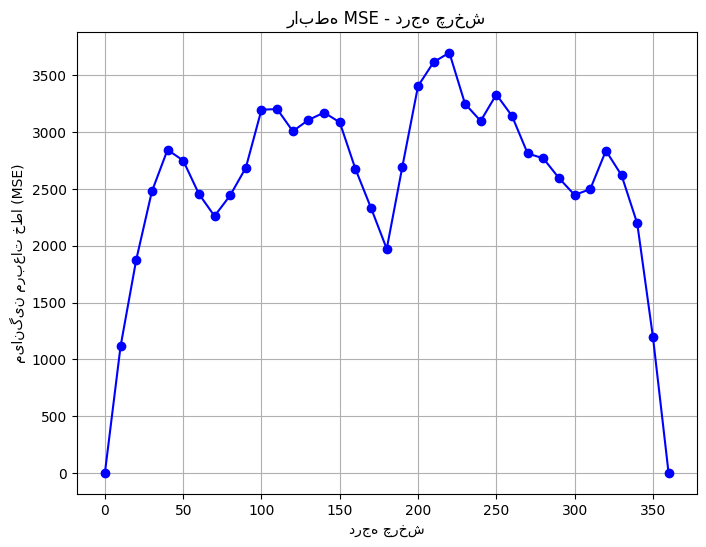

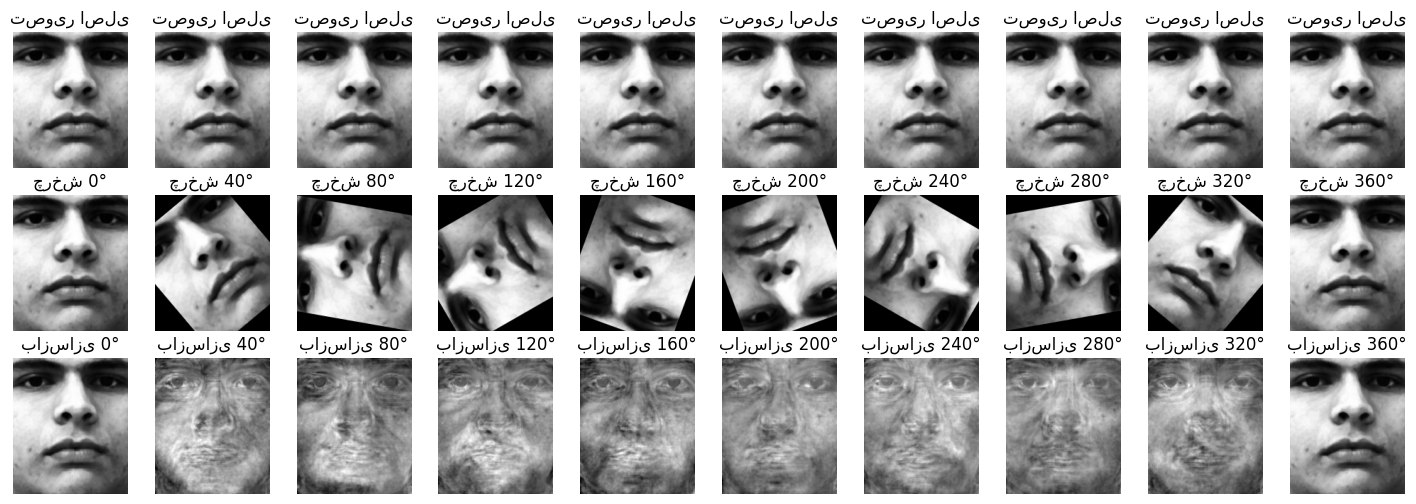

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# انتخاب یک تصویر تصادفی از دیتاست
random_idx = np.random.randint(1, 191)  # انتخاب از بین 190 تصویر طبیعی
selected_img = faces[random_idx][0]  # تصویر طبیعی (حالت عادی)

# بررسی ابعاد تصویر
h, w = selected_img.shape

# مقادیر دوران (از 0 تا 360 با گام‌های 10 درجه)
rotation_angles = np.arange(0, 361, 10)

# لیست برای ذخیره مقادیر MSE
mse_values_rotation = []

# لیست تصاویر برای نمایش (10 تصویر یکنواخت بین 0 تا 360)
selected_angles = np.linspace(0, 360, 10, dtype=int)
sample_rotated_images = []
sample_reconstructed_images = []

for angle in rotation_angles:
    # چرخش تصویر
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
    rotated_img = cv2.warpAffine(selected_img, M, (w, h))

    # بازسازی تصویر با استفاده از تمام PCها
    reconstructed_img, mse = reconstruct_image(rotated_img, eigenfaces)

    # ذخیره مقدار MSE
    mse_values_rotation.append(mse)

    # ذخیره برخی تصاویر برای نمایش (10 مقدار یکنواخت)
    if angle in selected_angles:
        sample_rotated_images.append(rotated_img)
        sample_reconstructed_images.append(reconstructed_img)

# ------------------------
# رسم نمودار MSE بر حسب درجه چرخش
plt.figure(figsize=(8,6))
plt.plot(rotation_angles, mse_values_rotation, 'bo-')
plt.xlabel("درجه چرخش")
plt.ylabel("میانگین مربعات خطا (MSE)")
plt.title("رابطه MSE - درجه چرخش")
plt.grid(True)
plt.show()

# ------------------------
# نمایش نمونه‌ای از تصاویر چرخش و بازسازی‌شده
fig, axes = plt.subplots(3, 10, figsize=(18, 6))

for i, angle in enumerate(selected_angles):
    # تصویر اصلی
    axes[0, i].imshow(selected_img, cmap='gray')
    axes[0, i].set_title(f"تصویر اصلی")
    axes[0, i].axis('off')

    # تصویر بعد از چرخش
    axes[1, i].imshow(sample_rotated_images[i], cmap='gray')
    axes[1, i].set_title(f"چرخش {angle}°")
    axes[1, i].axis('off')

    # تصویر بازسازی‌شده
    axes[2, i].imshow(sample_reconstructed_images[i], cmap='gray')
    axes[2, i].set_title(f"بازسازی {angle}°")
    axes[2, i].axis('off')

plt.show()
